**Part 3: Linear regression using the numerical data and all the categorical data**

In the part 0 we did some basic prepossing. We saw that there were 34 numerical features, and 45 categorical, for a total of 79 features. In part 1 we performed a linear regression using only the 34 numerical features. In part 2 we transformed 22 categorical features into numerical features via transformations, and performed a linear regression on the enlarged set of numerical features, 56 in total. In this part we remove those categorical values which we believe contain little information, incorporate the remaining categorical features using one-hot encoding. This replaces the categorical features with new numerical features, so that all features are now numerical. We then perform a linear regression on the result. We begin by reproducing steps 1 and 2 of part 2, cleaning up the code where possible. We won't use a dictionary to define the numerical transformations separately. Instead we directly give a list of categorical features to transform, and define the transformations in a single function. The advantage of this is that we can remove features from the list easily if we want to test different combinations of numerical transformations.

**Step 1: Reproduce steps 1-2 of part 2**

In [1]:
import pandas as pd
import numpy as np

# Import train and test data, save train SalePrice and test Id separately, remove train SalePrice and train and test Id
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
train.drop(['Id'], axis=1, inplace=True)
submission = test[['Id']]
test.drop(['Id'], axis=1, inplace=True)
train_sale_price = train[['SalePrice']]
train.drop(['SalePrice'], axis=1, inplace=True)

# Split features/columns into numerical and categorical lists
numeric_features_columns = list(train.select_dtypes(include=[np.number]).columns)
categorical_features_list_to_remove_from_numerical = ['MSSubClass', 'MoSold']
numeric_features_columns = list(set(numeric_features_columns) - set(categorical_features_list_to_remove_from_numerical))
train['MSSubClass'] = train['MSSubClass'].apply(str)
test['MSSubClass'] = test['MSSubClass'].apply(str)
train['MoSold'] = train['MoSold'].apply(str)
test['MoSold'] = test['MoSold'].apply(str)
categorical_features_columns = list(set(train.columns) - set(numeric_features_columns))

# Fill in the missing data
latest_year_house_sold = train['YrSold'].max()
train['GarageYrBlt'].fillna(latest_year_house_sold, inplace = True)
test['GarageYrBlt'].fillna(latest_year_house_sold, inplace = True)
train_numeric_features_with_missing_values = [feature for feature in numeric_features_columns if train[feature].isnull().sum() > 0]
test_numeric_features_with_missing_values = [feature for feature in numeric_features_columns if test[feature].isnull().sum() > 0]
train_categoric_features_with_missing_values = [feature for feature in categorical_features_columns if train[feature].isnull().sum() > 0]
test_categoric_features_with_missing_values = [feature for feature in categorical_features_columns if test[feature].isnull().sum() > 0]

for feature in train_numeric_features_with_missing_values:
    train[feature].fillna(0, inplace = True)

for feature in test_numeric_features_with_missing_values:
    test[feature].fillna(0, inplace = True)

categoric_features_with_NA = [
    'Alley',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'BsmtQual',
    'Fence',
    'FireplaceQu',
    'GarageCond',
    'GarageFinish',
    'GarageQual',
    'GarageType',
    'MiscFeature',
    'PoolQC'
]
for feature in train_categoric_features_with_missing_values:
    if feature in categoric_features_with_NA:
        train[feature].fillna('NA', inplace = True)
    else:
        train[feature].fillna(train[feature].value_counts().idxmax(), inplace = True)
        
for feature in test_categoric_features_with_missing_values:
    if feature in categoric_features_with_NA:
        test[feature].fillna('NA', inplace = True)
    else:
        test[feature].fillna(test[feature].value_counts().idxmax(), inplace = True)

# Convert year features to age features
year_features = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']
train['AgeOfHouse'] = train['YrSold'] - train['YearBuilt']
train['AgeOfRemodAdd'] = train['YrSold'] - train['YearRemodAdd']
train['AgeOfGarage'] = train['YrSold'] - train['GarageYrBlt']
train['AgeOfSale'] = latest_year_house_sold - train['YrSold']
test['AgeOfHouse'] = test['YrSold'] - test['YearBuilt']
test['AgeOfRemodAdd'] = test['YrSold'] - test['YearRemodAdd']
test['AgeOfGarage'] = test['YrSold'] - test['GarageYrBlt']
test['AgeOfSale'] = latest_year_house_sold - test['YrSold']
age_features = ['AgeOfHouse', 'AgeOfRemodAdd', 'AgeOfGarage', 'AgeOfSale']
train.drop(year_features, axis=1, inplace=True)
test.drop(year_features, axis=1, inplace=True)
numeric_features_columns = list(set(numeric_features_columns) - set(year_features))
numeric_features_columns = list(set(numeric_features_columns).union(set(age_features)))

# Log transformation of train SalePrice
train_sale_price['SalePrice'] = train_sale_price['SalePrice'].apply(np.log)

# Define categorical features to transform to categorical, and the chosen numerical transformations
categorical_features_to_convert_to_numerical = [
    'Alley',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'BsmtQual',
    'CentralAir',
    'ExterCond',
    'ExterQual',
    'Fence',
    'FireplaceQu',
    'Functional',
    'GarageCond',
    'GarageFinish',
    'GarageQual',
    'HeatingQC',
    'KitchenQual',
    'LandSlope',
    'PavedDrive',
    'PoolQC',
    'Street',
    'Utilities'
]

def numerical_transformations(feature, x):
    if feature in ['ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual', 'PoolQC']:
        if x == 'Ex':
            return 4
        elif x == 'Gd':
            return 3
        elif x == 'TA':
            return 2
        elif x == 'Fa':
            return 1
        else:
            return 0

    if feature in ['BsmtCond', 'FireplaceQu', 'GarageQual', 'GarageCond']: 
        if x == 'Ex':
            return 5
        elif x == 'Gd':
            return 4
        elif x == 'TA':
            return 3
        elif x == 'Fa':
            return 2
        elif x == 'Po':
            return 1
        else:
            return 0

    if feature in ['BsmtFinType1', 'BsmtFinType2']:
        if x == 'GLQ':
            return 6
        elif x == 'ALQ':
            return 5
        elif x == 'BLQ':
            return 4
        elif x == 'Rec':
            return 3
        elif x == 'LwQ':
            return 2
        elif x == 'Unf':
            return 1
        else:
            return 0

    if feature == 'BsmtExposure':
        if x == 'Gd':
            return 4
        elif x == 'Av':
            return 3
        elif x == 'Mn':
            return 2
        elif x == 'No':
            return 1
        else:
            return 0

    if feature == 'Functional':
        if x == 'Typ':
            return 7
        elif x == 'Min1':
            return 6
        elif x == 'Min2':
            return 5
        elif x == 'Mod':
            return 4
        elif x == 'Maj1':
            return 3
        elif x == 'Maj2':
            return 2
        elif x == 'Sev':
            return 1
        else:
            return 0

    if feature == 'GarageFinish':
        if x == 'Fin':
            return 3
        elif x == 'RFn':
            return 2
        elif x == 'Unf':
            return 1
        else:
            return 0

    if feature == 'Fence':
        if x == 'GdPrv':
            return 4
        elif x == 'MnPrv':
            return 3
        elif x == 'GdWo':
            return 2
        elif x == 'MnWw':
            return 1
        else:
            return 0

    if feature == 'BsmtQual':
        if x == 'Ex':
            return 105
        elif x == 'Gd':
            return 95
        elif x == 'TA':
            return 85
        elif x == 'Fa':
            return 75
        elif x == 'Po':
            return 65
        else:
            return 0
        
    if feature == 'CentralAir':
        if x == 'Y':
            return 1
        else:
            return 0
        
    if feature == 'Street':
        if x == 'Pave':
            return 1
        else:
            return 0

    if feature == 'Alley':
        if x == 'Grvl' or x == 'Pave':
            return 1
        else:
            return 0

    if feature == 'LandSlope':
        if x == 'Gtl':
            return 1
        else:
            return 0
        
    if feature == 'PavedDrive':
        if x == 'Y' or x == 'P':
            return 1
        else:
            return 0
    
    if feature == 'Utilities':
        if x == 'AllPub':
            return 1
        else:
            return 0

# Transform the chosen categorical features using the numerical chosen transformations
for feature in categorical_features_to_convert_to_numerical:
    train[feature] = train[feature].apply(lambda x: numerical_transformations(feature, x))
    test[feature] = test[feature].apply(lambda x: numerical_transformations(feature, x))
    categorical_features_columns.remove(feature)
    numeric_features_columns.append(feature)

print(len(numeric_features_columns))
print(len(categorical_features_columns))

56
23


/home/tmetcalfe/Documents/machine-learning/anaconda3/envs/house-prices-tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


There are 56 numerical features and 23 categorical features.

**Step 2: Removing categorical features with too few unique entries**

Before incorporating the remaining categorical features we choose to remove those categorical features which we believe contribute little information. We investigate those features in the same way as in step 2 of part 2: We identify and examine those features for which a single value occurs in at least 90% of all data in either train or test.

In [2]:
train_categorical_features_with_few_unique_entries = [feature for feature in categorical_features_columns if train[feature].value_counts()[0]/len(train.index) > 0.9]
test_categorical_features_with_few_unique_entries = [feature for feature in categorical_features_columns if test[feature].value_counts()[0]/len(test.index) > 0.9]
categorical_features_list_with_too_few_unique_entries = list(set(train_categorical_features_with_few_unique_entries).union(set(test_categorical_features_with_few_unique_entries)))

print(categorical_features_list_with_too_few_unique_entries)
print('')
for feature in categorical_features_list_with_too_few_unique_entries:
    print(train[feature].value_counts())
    print('')
    print(test[feature].value_counts())
    print('')
    print('')

['MiscFeature', 'RoofMatl', 'Electrical', 'Condition2', 'Heating']

NA      1406
Shed      49
Othr       2
Gar2       2
TenC       1
Name: MiscFeature, dtype: int64

NA      1408
Shed      46
Gar2       3
Othr       2
Name: MiscFeature, dtype: int64


CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
Metal         1
Roll          1
Membran       1
ClyTile       1
Name: RoofMatl, dtype: int64

CompShg    1442
Tar&Grv      12
WdShake       4
WdShngl       1
Name: RoofMatl, dtype: int64


SBrkr    1335
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

SBrkr    1337
FuseA      94
FuseF      23
FuseP       5
Name: Electrical, dtype: int64


Norm      1445
Feedr        6
RRNn         2
Artery       2
PosN         2
RRAe         1
RRAn         1
PosA         1
Name: Condition2, dtype: int64

Norm      1444
Feedr        7
Artery       3
PosA         3
PosN         2
Name: Condition2, dtype: int64


GasA     1428
GasW       18
Grav        7
Wa

We can see, for example, that Heating is dominated by the single value GasA. It is clear intuitively that there is little information to be gained by including this feature, and we therefore choose to remove it. We similarly choose to remove all of these features.

In [3]:
categorical_features_columns = list(set(categorical_features_columns) - set(categorical_features_list_with_too_few_unique_entries)) # Remove these features from the categorical feature list
train.drop(categorical_features_list_with_too_few_unique_entries, axis=1, inplace=True) # Drop these feature columns from train
test.drop(categorical_features_list_with_too_few_unique_entries, axis=1, inplace=True) # Drop these feature columns from test
print(len(numeric_features_columns)) # Number of numerical features
print(len(categorical_features_columns)) # Number of categorical features

56
18


There are now 56 numeric features and 18 categoricals. Why did we remove these features? We did so in an attempt to reduce noise. We will discuss noise in more detail in parts 4 and 5 when we examine correlations. Why 90%? Simply because that figure seems reasonable to us!! A different choice may work better. For now however, we continue.

**Step 3: One-hot encoding of the remaining categorical features**

We now convert the 18 remaining categorical features into numerical features via one-hot encoding. We use the library pd.get_dummies. To explain what happens, consider the following dataframe.

In [4]:
example_dataframe = pd.DataFrame(data = {'COL': ['a', 'b', 'a', 'c']})
example_dataframe

,COL
0,a
1,b
2,a
3,c


We now apply pd.get_dummies to column COL of example_dataframe and examine the result.

In [5]:
dummy_transformation = pd.get_dummies(example_dataframe['COL'])
dummy_transformation

,a,b,c
0,1,0,0
1,0,1,0
2,1,0,0
3,0,0,1


dummy_transformation is a new dataframe with the same number of rows as example_dataframe, and with a column for each value ('a' and 'b' and 'c') in column COL. dummy_transformation is numerical and only has values 0 and 1. In the 'a' column, value 1 in a row means that row had COL value 'a', and value 0 means that row did not have SaleType value 'a'. Similarly for columns 'b' and 'c'.

Next let us consider an example from train.

In [6]:
train[['SaleType']].head()

,SaleType
0,WD
1,WD
2,WD
3,WD
4,WD


According to data_description.txt:

SaleType: Type of sale
		
    WD 	Warranty Deed - Conventional
    CWD	Warranty Deed - Cash
    VWD	Warranty Deed - VA Loan
    New	Home just constructed and sold
    COD	Court Officer Deed/Estate
    Con	Contract 15% Down payment regular terms
    ConLw	Contract Low Down payment and low interest
    ConLI	Contract Low Interest
    ConLD	Contract Low Down
    Oth	Other
       
There are 10 possible values for this feature. Let us now apply pd.get_dummies.

In [7]:
pd.get_dummies(train['SaleType']).head()

,COD,CWD,Con,ConLD,ConLI,ConLw,New,Oth,WD
0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,1


The first 5 entries in column WD have value 1, and all other values in the other columns are 0, since the first 5 entries of train SaleType has value WD.

Note, there is no column corresponding to SaleType value VWD. This is because train SaleType never actually takes value VMD, and so no corresponding column is created:

In [8]:
train['SaleType'].value_counts() # How many times does each value appear in train SaleType?

WD       1267
New       122
COD        43
ConLD       9
ConLI       5
ConLw       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64

We do the following for each train categorical feature:

    Create the dummy dataframes corresponding to that feature.
    Join the dummy dataframe to train.
    Remove the original categorical feature column from train.
    
We do similarly for each test categorical feature.

In [9]:
def train_dummy_features_constructor(feature):
    return pd.get_dummies(train[feature]).rename(columns=lambda x: (feature + '_' + str(x))) # The train one-hot encoded numerical dataframe for this train feature. The columns are renamed to remember the name of the train feature.

def test_dummy_features_constructor(feature):
    return pd.get_dummies(test[feature]).rename(columns=lambda x: (feature + '_' + str(x))) # The test one-hot encoded numerical dataframe for this test feature.

for feature in categorical_features_columns:    
    train = pd.concat([train,train_dummy_features_constructor(feature)], axis=1) # Add the train one-hot encoded numerical dataframe for this train feature to the train dataframe
    test = pd.concat([test,test_dummy_features_constructor(feature)], axis=1) # Add the test one-hot encoded numerical dataframe for this test feature to the test dataframe
    train.drop([feature], axis=1, inplace=True) # Remove the train feature column from the train dataframe
    test.drop([feature], axis=1, inplace=True) # Remove the test feature column from the test dataframe

 Let us see how the train and test dataframes have been altered.

In [10]:
print(train.shape)
train.head()

(1460, 217)


,LotFrontage,LotArea,Street,Alley,Utilities,LandSlope,OverallQual,OverallCond,MasVnrArea,ExterQual,...,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE
0,65.0,8450,1,0,1,1,7,5,196.0,3,...,0,0,0,0,0,1,0,0,0,0
1,80.0,9600,1,0,1,1,6,8,0.0,2,...,1,0,0,0,0,1,0,0,0,0
2,68.0,11250,1,0,1,1,7,5,162.0,3,...,0,0,0,0,1,1,0,0,0,0
3,60.0,9550,1,0,1,1,7,5,0.0,2,...,0,0,0,0,0,1,0,0,0,0
4,84.0,14260,1,0,1,1,8,5,350.0,3,...,0,0,0,0,0,1,0,0,0,0


In [11]:
print(test.shape)
test.head()

(1459, 214)


,LotFrontage,LotArea,Street,Alley,Utilities,LandSlope,OverallQual,OverallCond,MasVnrArea,ExterQual,...,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE
0,80.0,11622,1,0,1,1,5,6,0.0,2,...,0,1,0,0,0,1,0,0,0,0
1,81.0,14267,1,0,1,1,6,6,108.0,2,...,0,1,0,0,0,1,0,0,0,0
2,74.0,13830,1,0,1,1,5,5,0.0,2,...,0,0,0,0,0,1,0,0,0,0
3,78.0,9978,1,0,1,1,6,6,20.0,2,...,0,1,0,0,0,1,0,0,0,0
4,43.0,5005,1,0,1,1,8,5,0.0,3,...,0,0,0,0,0,0,0,0,0,1


We can see the new numerical columns which have been created. However, one thing that should be setting off alarm bells is the following: train and test have a different number of columns. This is beacuse, as mentioned above, not all features take all possible values (for example, train SaleType never actually takes value VMD). We cannot perform linear regression until we correct for this. Let us investigate the differences in the columns between train and test.

In [12]:
columns_in_train_but_not_test = list(set(train.columns) - set(test.columns)) # List of the train columns which have no equivalent test columns
columns_in_test_but_not_train = list(set(test.columns) - set(train.columns)) # List of the test columns which have no equivalent train columns
print(columns_in_train_but_not_test)
print(columns_in_test_but_not_train)

['Exterior1st_ImStucc', 'HouseStyle_2.5Fin', 'Exterior2nd_Other', 'Exterior1st_Stone']
['MSSubClass_150']


In [13]:
test['MSSubClass_150'].value_counts() # How many times does each value appear in test MSSubClass_150?

0    1458
1       1
Name: MSSubClass_150, dtype: int64

As we can see above, test MSSubClass_150 has value 1 only once, with all 1458 other values having value 0. Since there is not much variation in this column we won't lose much information by simply removing it. Similarly, all train columns in columns_in_train_but_not_test have not much variation, and we simply remove them. Then the columns in train and test should be the same.

In [14]:
train.drop(columns_in_train_but_not_test, axis=1, inplace=True) # Drop columns in train but not in test from train
test.drop(columns_in_test_but_not_train, axis=1, inplace=True) # Drop columns in test but not in train from test
list(train.columns) == list(test.columns) # Check that the columns in train and test are now the same

True

In [15]:
print(len(numeric_features_columns))
print(train.shape)
print(test.shape)

56
(1460, 213)
(1459, 213)


As a reminder, numeric_features_columns represents the original 34 numerical features, and the 22 categorical features that we converted into numerical features via transformations in part 2. The other 157 = 213-56 numerical features were constructed from the categorical features via one-hot encoding. The entire train and test dataframes are now numerical.

**Step 4: Linear regression**

We now make our third set of predictions: Linear regression using the entire train and test dataframes which are now numerical. First the train test split. The code is almost identical to that in step 2 of part 1 except we are now using the train dataframe.

0.14480982640361656


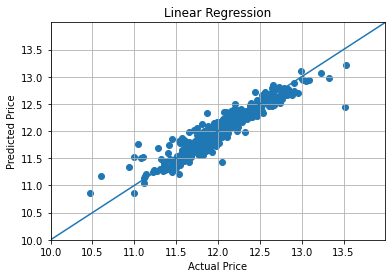

In [16]:
X = train.copy() # Now we can use all of train as everything is numerical
Y = train_sale_price.copy()

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=.33)
actual_log_prices = y_test

lr = linear_model.LinearRegression()
model = lr.fit(x_train, y_train)
predicted_log_prices = model.predict(x_test)
predicted_log_prices = pd.DataFrame(predicted_log_prices, columns = ['SalePrice'])

print(np.sqrt(mean_squared_error(predicted_log_prices, actual_log_prices)))

fig = plt.figure()
ax = fig.gca()
ax.set_xticks(np.arange(10, 14, .5))
ax.set_yticks(np.arange(10, 14, .5))
plt.xlim(10,  14)
plt.ylim(10, 14)
plt.plot([10,14], [10,14])
plt.grid()
plt.scatter(actual_log_prices, predicted_log_prices)
plt.ylabel('Predicted Price')
plt.xlabel('Actual Price')
plt.title('Linear Regression')
plt.show() 

Next the linear regression using the whole of X and Y.

In [17]:
model = lr.fit(X, Y)
X_test = test.copy() # Now we can use all of test as everything is numerical
predicted_log_prices = model.predict(X_test)
predicted_log_prices = pd.DataFrame(predicted_log_prices, columns = ['SalePrice'])

submission['SalePrice'] = predicted_log_prices['SalePrice'].apply(np.exp)
submission.to_csv('submission.csv',index=False)

Submitting this file to kaggle gives a **RMSE score of 0.14227**. This is slightly better than the result in part 2. Of course, we really had no reason to believe than the sale price should depend linearly on the one-hot encoded categoricals, so it is not terribly surprising that we have not obtained a much better result.